In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from env_utils import PDUSession
from nfv_allocation_env import NfvAllocEnv
from sb3_contrib import MaskablePPO

2024-05-15 15:58:18.334155: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 15:58:18.336144: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 15:58:18.363236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 15:58:18.363259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 15:58:18.364160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
drl_model = MaskablePPO.load('saved models/PPO_scale1.5_env8_nuc_seed2_g05_qi359_p631')
qi_dict = {3:0.6, 5:0.3, 9:0.1}
f = open('5qi_table.json')
qi_table = json.load(f)

def drl_policy(obs, mask):
    action, _states = drl_model.predict(obs, action_masks=mask)
    return action

In [3]:
# return the host with the lowest current energy that is not full. How to handle on/off nodes?
def energy_greedy_policy(obs, action_mask):
    # energy greedy alway choose the cloud?
    action = 0
    return action

In [4]:
# return the host with the lowest latency that is not full. How to handle on/off nodes?
def latency_greedy_policy(obs, action_mask):
    available_hosts = np.argwhere(mask).flatten()
    #print('available hosts: ',available_hosts)
    latencies = obs[:,3]
    #print('latencies: ', latencies)
    action = available_hosts[np.argmin(latencies[available_hosts])]
    #print('action: ',action)
    return action

In [5]:
def random_action_policy(obs, action_mask):
    action = np.random.randint(action_mask.size)
    return action_mask[action]

In [6]:
#choose the host with maximum latency between the ones that satisfy the required latency otherwise minimize latency error
def latency_smart_policy(obs, action_mask):
    available_hosts = np.argwhere(mask).flatten()
    #print('available hosts: ',available_hosts)
    latencies = obs[:,3]
    #print('latencies: ', latencies)
    #required_lat = PDUSession.latencies[int(obs[0,4])]
    req_qi = int(obs[0,4])
    required_lat = qi_table[str(req_qi)]["delay"]
    #print('required lat: ', required_lat)
    
    av_latencies = latencies[available_hosts]
    good_latencies = np.where(av_latencies <= required_lat)[0]
    #print('good latencies: ', good_latencies)
    if good_latencies.size != 0:
        #print('smart!')
        action = available_hosts[good_latencies[np.argmax(latencies[good_latencies])]]
    else:
        action = available_hosts[np.argmin(latencies[available_hosts])]
    #print('action: ',action)
    return action

In [7]:
qi_dict = {3:0.6, 5:0.3, 9:0.1}
env_par={'config_file': 'nuc_host_models-4.json', 'dt_scale': 1, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
env = NfvAllocEnv(**env_par)

seed = 10
n_steps = 100_000

step_data = []
run_data = []

[<env_utils.EdgeHost object at 0x7c581762be50>, <env_utils.EdgeHost object at 0x7c581762b220>, <env_utils.EdgeHost object at 0x7c581762b250>]


In [8]:
#DRL
drl_lat_errors = []
drl_ppmbit = []

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = drl_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    drl_lat_errors.append(info['latency_error'])
    drl_ppmbit.append(info['power_per_mbit'])
    step_data.append(["drl", step, info['power_per_mbit'], reward])
run_data.append(["drl", np.count_nonzero(drl_lat_errors)/n_steps*100] )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
#LATENCY GREEDY
#n_steps = 1000
lg_lat_errors = []
lg_ppmbit = []

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = latency_greedy_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    lg_lat_errors.append(info['latency_error'])
    lg_ppmbit.append(info['power_per_mbit'])
    step_data.append(["latency greedy", step, info['power_per_mbit'], reward])
run_data.append(["latency greedy", np.count_nonzero(lg_lat_errors)/n_steps*100] )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
#ENERGY GREEDY
#n_steps = 1000
eg_lat_errors = []
eg_ppmbit = []

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = energy_greedy_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    eg_lat_errors.append(info['latency_error'])
    eg_ppmbit.append(info['power_per_mbit'])
    step_data.append(["energy greedy", step, info['power_per_mbit'], reward])
run_data.append(["energy greedy", np.count_nonzero(eg_lat_errors)/n_steps*100] )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
#RANDOM ACTION
#n_steps = 1000
rand_lat_errors = []
rand_ppmbit = []

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = random_action_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    rand_lat_errors.append(info['latency_error'])
    rand_ppmbit.append(info['power_per_mbit'])
    step_data.append(["random action", step, info['power_per_mbit'], reward])
run_data.append(["random action", np.count_nonzero(rand_lat_errors)/n_steps*100] )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
#LATENCY SMART
#n_steps = 1000
ls_lat_errors = []
ls_ppmbit = []

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = latency_smart_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    ls_lat_errors.append(info['latency_error'])
    ls_ppmbit.append(info['power_per_mbit'])
    step_data.append(["latency smart", step, info['power_per_mbit'], reward])
run_data.append(["latency smart", np.count_nonzero(ls_lat_errors)/n_steps*100] )

  0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
step_df = pd.DataFrame(step_data, columns=['algorithm', 'step','power', 'reward'])
run_df = pd.DataFrame(run_data, columns=['algorithm', 'error percent'])

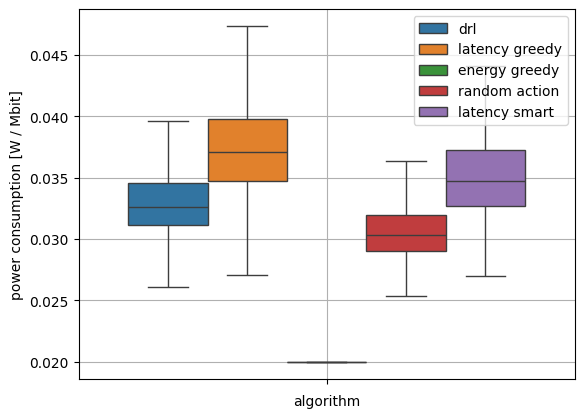

In [55]:
sns.boxplot(data=step_df, y="power", hue="algorithm", showfliers=False)
plt.xlabel("algorithm")
plt.ylabel("power consumption [W / Mbit]")
plt.grid()
plt.legend( loc=1)

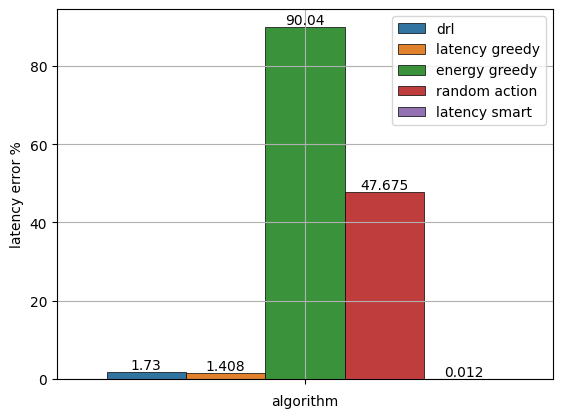

In [45]:
ax=sns.barplot(data=run_df, y="error percent", hue="algorithm", linewidth=.5, edgecolor="0")
plt.ylabel("latency error %")
plt.xlabel("algorithm")
plt.grid()
#plt.yscale('log')
ax.legend_.set_title(None)
for i in ax.containers:
    ax.bar_label(i,)

(-1.0, 0.0)

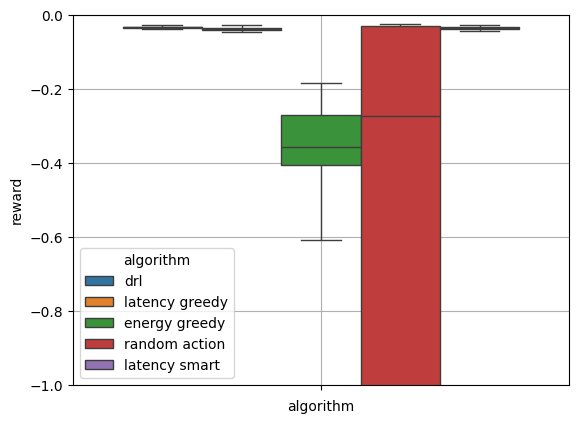

In [16]:
ax = sns.boxplot(data=step_df, y="reward", hue="algorithm", showfliers=False)
plt.xlabel("algorithm")
plt.grid()
plt.ylim(-1, 0)

Latency Smart algorithm performs better in this case because the host with the highest latency inside the requirements also has the lowest power consumption

In [17]:
#plt.plot(lg_lat_errors, label='lat greedy', alpha=0.5)
#plt.plot(eg_lat_errors, label='energy greedy', alpha=0.5)
#plt.plot(rand_lat_errors, label='random action', alpha=0.5)
#plt.plot(ls_lat_errors, label='lat smart', alpha=0.5)
#plt.axhline(y=np.nanmean(lg_lat_errors))
#plt.axhline(y=np.nanmean(eg_lat_errors), color='tab:orange')
#plt.title('latency errors')
#plt.legend()
#plt.show()

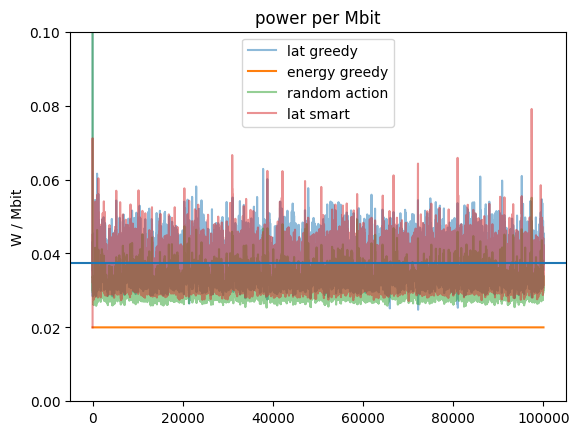

In [18]:
plt.plot(lg_ppmbit, label='lat greedy', alpha=0.5)
plt.plot(eg_ppmbit, label='energy greedy')
plt.plot(rand_ppmbit, label='random action', alpha=0.5)
plt.plot(ls_ppmbit, label='lat smart', alpha=0.5)
plt.axhline(y=np.nanmean(lg_ppmbit))
plt.ylim(0, 0.1) 
plt.ylabel('W / Mbit')
plt.title('power per Mbit')
plt.legend()
plt.show()

In [19]:
import pandas as pd
import seaborn as sns

In [20]:
powerdata = pd.read_csv("data/PPO_scale1.5_env8_nuc_seed2_g05_qi359_p631_power.csv")
latdata = pd.read_csv("data/PPO_scale1.5_env8_nuc_seed2_g05_qi359_p631_latency.csv")

#powerdata = pd.read_csv("data/PPO_scale1_C1_ppmbit.csv")
#latdata = pd.read_csv("data/PPO_scale1_C1_latency-error.csv")

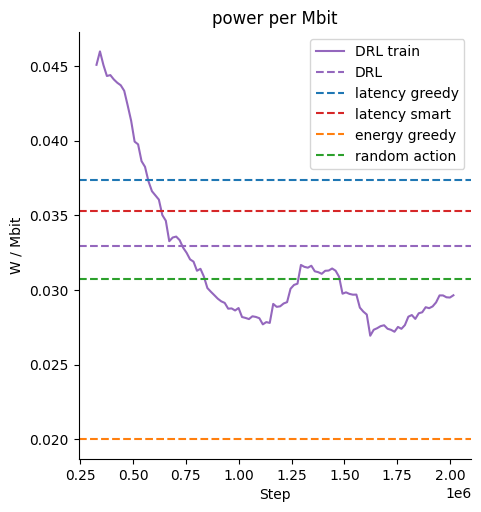

In [21]:
powerdata['SMA20'] = powerdata['Value'].rolling(20).mean()
powerdata.dropna(inplace=True)

#sns.relplot(data=powerdata,kind="line", x="Step", y="Value")
sns.relplot(data=powerdata,kind="line", x="Step", y="SMA20", label='DRL train', color='tab:purple')
plt.axhline(y=np.nanmean(drl_ppmbit), color='tab:purple', label='DRL', linestyle='dashed')
#powerdata[['Value','SMA20']].plot()
#plt.axhline(y=np.nanmean(powerdata['Value']), color='tab:purple', label='DRL', linestyle='dashed')
plt.axhline(y=np.nanmean(lg_ppmbit), color='tab:blue', label='latency greedy', linestyle='dashed')
plt.axhline(y=np.nanmean(ls_ppmbit), color='tab:red', label='latency smart', linestyle='dashed')
plt.axhline(y=np.nanmean(eg_ppmbit), color='tab:orange', label='energy greedy', linestyle='dashed')
plt.axhline(y=np.nanmean(rand_ppmbit), color='tab:green', label='random action', linestyle='dashed')
plt.ylabel('W / Mbit')
plt.title('power per Mbit')
plt.legend()
plt.show()

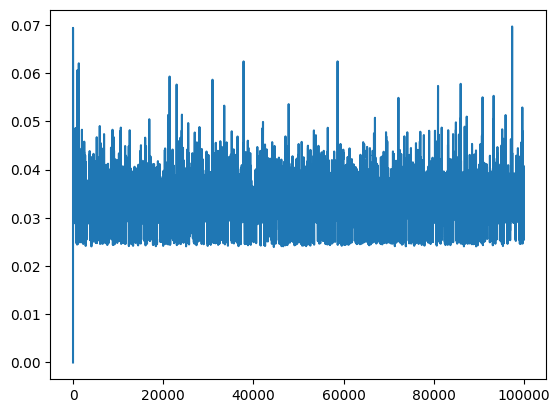

In [22]:
drl_ppmbit[0]=0
plt.plot(drl_ppmbit)

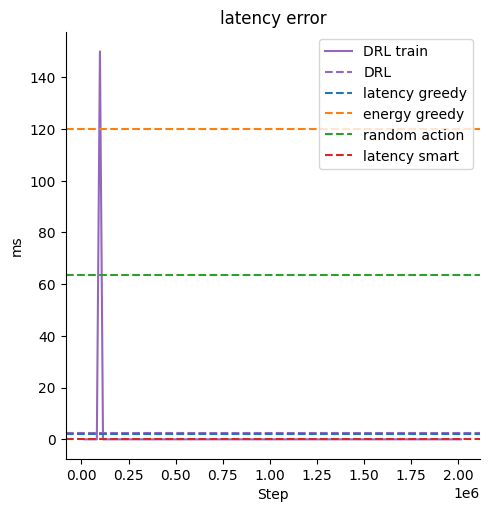

In [23]:
latdata['SMA20'] = latdata['Value'].ewm(span=20).mean()
latdata.dropna(inplace=True)

sns.relplot(data=latdata,kind="line", x="Step", y="Value", label='DRL train', color='tab:purple')
#plt.axhline(y=np.nanmean(latdata['Value']), color='tab:purple', label='DRL', linestyle='dashed')
plt.axhline(y=np.nanmean(drl_lat_errors), color='tab:purple', label='DRL', linestyle='dashed')
plt.axhline(y=np.nanmean(lg_lat_errors), color='tab:blue', label='latency greedy', linestyle='dashed')
plt.axhline(y=np.nanmean(eg_lat_errors), color='tab:orange', label='energy greedy', linestyle='dashed')
plt.axhline(y=np.nanmean(rand_lat_errors), color='tab:green', label='random action', linestyle='dashed')
plt.axhline(y=np.nanmean(ls_lat_errors), color='tab:red', label='latency smart', linestyle='dashed')
#plt.plot(ls_lat_errors, label='lat smart', color='tab:red')
plt.ylabel('ms')
plt.title('latency error')
plt.legend()
plt.show()

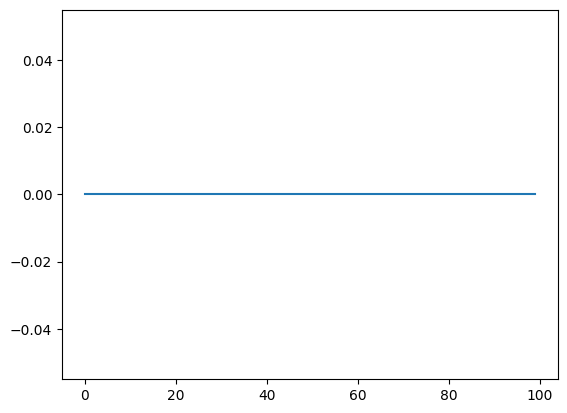

In [24]:
drl_ppmbit[0]=0
plt.plot(drl_lat_errors[0:100])

In [25]:
#latdata['error rate'] = latdata['Value'].gt(0).rolling(100).sum()

print(latdata['Value'].size)

latsmart = pd.Series(ls_lat_errors).gt(0).rolling(1000).sum()
#plt.plot(latsmart)
#plt.plot(latdata['Step'],latdata['error rate'])
#sns.relplot(latdata['error rate'],kind="line")

123


In [26]:
#The Latency Greedy policy has worse performance than the DRL?
print('--- average error in ms ---')
print('greedy:',np.nanmean(lg_lat_errors))
print('smart:',np.nanmean(ls_lat_errors))
print('drl:',np.nanmean(drl_lat_errors))
print('drl train:',np.nanmean(latdata['Value']))

print('--- error percentage ---')
print('greedy:',pd.Series(lg_lat_errors).gt(0).sum()/len(lg_lat_errors)*100)
print('smart:',pd.Series(ls_lat_errors).gt(0).sum()/len(ls_lat_errors)*100)
print('drl:',pd.Series(drl_lat_errors).gt(0).sum()/len(drl_lat_errors)*100)
print('drl train:',(latdata['Value']).gt(0).sum()/latdata['Value'].size*100)

--- average error in ms ---
greedy: 1.884
smart: 0.016
drl: 2.3175
drl train: 1.2195121951219512
--- error percentage ---
greedy: 1.4080000000000001
smart: 0.012
drl: 1.73
drl train: 0.8130081300813009


In [27]:
a = np.array([0,1,5,7,2,9])
w = np.where(a>3)
print(w)
print(w==True)

(array([2, 3, 5]),)
False


<Axes: >

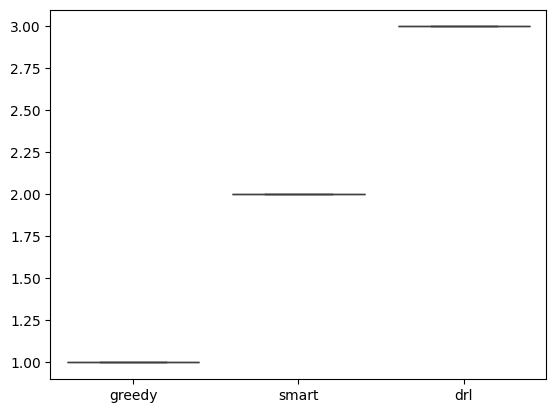

In [28]:
sns.boxplot(x=['greedy','smart','drl'], y=[1,2,3])